By Raiyan Abdul Baten

University of Rochester, NY, USA

Mail: raiyanabdulbaten@gmail.com

# Ridge Regression 
## Implementation and Cheat Sheet

This page documents the summary theory and implementation of ridge regression. In particular, it covers:

- Ridge regression
- k-fold cross validation to find best l2-penalty

In [1]:
import pandas as pd
import os
import numpy as np
import re
import csv
from IPython.display import display, Math, Latex
from sklearn import datasets, linear_model
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

def load_csv_data(folder_name, file_name, dtype_dict=None):
    csv_path = os.path.join(folder_name, file_name+".csv")
    return pd.read_csv(csv_path, dtype=dtype_dict)

# Loading data

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, \
              'sqft_living15':float, 'grade':int, 'yr_renovated':int, \
              'price':float, 'bedrooms':float, 'zipcode':str, \
              'long':float, 'sqft_lot15':float, 'sqft_living':float, \
              'floors':str, 'condition':int, 'lat':float, 'date':str, \
              'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

In [3]:
df_train_ridge = load_csv_data("data","kc_house_train_data",dtype_dict)
df_test_ridge = load_csv_data("data","kc_house_test_data",dtype_dict)

# Ridge Regression

Regression model:

\begin{equation}
\mathbf{y}=\mathbf{X}\mathbf{w}+\mathbf{\epsilon},
\end{equation}
where $\mathbf{y}\in \mathbb{R}^{N\times 1}, \mathbf{X}\in \mathbb{R}^{N\times p}, \mathbf{w}\in \mathbb{R}^{p\times 1},\mathbf{\epsilon}\in \mathbb{R}^{N\times 1}$

Total cost = measure of fit + measure of magnitude of coefficients = $\text{RSS}(\mathbf{w}) + \lambda||\mathbf{w}||_2^2$

where $||\mathbf{w}||_2^2 = w_0^2+w_1^2+...+w_{p-1}^2$. Here, $w_0$ is the intercept, and there are $p-1$ actual features, giving a total of $p$ features.

Here,
\begin{equation}
 \text{RSS}(\mathbf{w}) = (\mathbf{y}-\mathbf{\hat{y}})^\text{T}(\mathbf{y}-\mathbf{\hat{y}}) = (\mathbf{y}-\mathbf{X}\mathbf{w})^\text{T}(\mathbf{y}-\mathbf{X}\mathbf{w})
\end{equation}

and

\begin{equation}
 ||\mathbf{w}||_2^2 = \mathbf{w}^{\text{T}}\mathbf{w}
\end{equation}

Therefore,

\begin{equation}
\text{Total cost} = (\mathbf{y}-\mathbf{X}\mathbf{w})^\text{T}(\mathbf{y}-\mathbf{X}\mathbf{w}) + \lambda \mathbf{w}^{\text{T}}\mathbf{w}
\end{equation}

Taking the gradient of the cost,
\begin{equation}
 \nabla (\text{RSS}(\mathbf{w}) + \lambda||\mathbf{w}||_2^2) = \nabla ((\mathbf{y}-\mathbf{X}\mathbf{w})^\text{T}(\mathbf{y}-\mathbf{X}\mathbf{w}) + \lambda \mathbf{w}^{\text{T}}\mathbf{w}) 
 \end{equation}
 \begin{equation}
 = -2\mathbf{X}^\text{T}(\mathbf{y}-\mathbf{X}\mathbf{w}) + \lambda (2 \mathbf{w}) = -2\mathbf{X}^\text{T}(\mathbf{y}-\mathbf{X}\mathbf{w}) + 2\lambda \mathbb{I}\mathbf{w}
\end{equation}


The closed form solution can be found by setting the gradient to 0:


\begin{equation}
 \nabla (\text{cost}(\mathbf{\hat{w}})) = \nabla (-2\mathbf{X}^\text{T}(\mathbf{y}-\mathbf{X}\mathbf{\hat{w}}) + 2\lambda \mathbb{I}\mathbf{\hat{w}}) = 0 
  \end{equation}
 \begin{equation}
 \mathbf{\hat{w}}^{\text{ridge}} = (\mathbf{X}^{\text{T}}\mathbf{X}+\lambda \mathbb{I})^{-1} \mathbf{X}^{\text{T}}\mathbf{y}
\end{equation}

However, we do not want to penalize the intercept $w_0$ for being large. Therefore, use a modified $\mathbb{I}^{\text{mod}} = \begin{bmatrix}0 &  & & &\\  & 1 &  & & \\ &  & 1 &  &\\  &  &  & \ddots & \\&  & & & 1 \end{bmatrix}$, with $\mathbb{I}\in\mathbb{R}^{p\times p}$


Using Gradient Descent:

init $t=1, \mathbf{w}^{(1)}=0$ or randomly or smartly

while $||\nabla \text{RSS}(\mathbf{w}^{(t)})||>$threshold:

\begin{equation}
\mathbf{w}^{(t+1)} <= \mathbf{w}^{(t)} +2\eta(\mathbf{X}^\text{T}(\mathbf{y}-\mathbf{X}\mathbf{w}^{(t)})-\lambda\mathbb{I}^{\text{mod}}\mathbf{w})\\
\end{equation}

In [4]:
def ridge_regression_gradient_descent(feature_matrix, target, initial_weights,\
                                      step_size, l2_penalty, max_iterations=100):
    
    weights = np.array(initial_weights)
    I = np.identity(weights.size)
    I[0][0]=0
    for iteration in range(max_iterations):
        gradient_RSS = -2*np.matmul(np.transpose(feature_matrix),target-np.matmul(feature_matrix,weights))
        gradient_regularization = 2*l2_penalty*np.matmul(I,weights)
        total_cost=gradient_RSS+gradient_regularization
        weights = weights - step_size*total_cost
    return(weights)

In [5]:
def ridge_regression_closed_form(feature_matrix,target,l2_penalty):
    I = np.identity(feature_matrix.shape[1])
    I[0][0]=0
    weights = np.matmul(np.linalg.inv(np.matmul(np.transpose(feature_matrix),feature_matrix)+l2_penalty*I),\
                        np.matmul(np.transpose(feature_matrix),target))
    return(weights)

In [6]:
def dataframe_prepare(dataframe,features,target):
    dataframe["constant"]=1
    one_padded_features=["constant"]
    one_padded_features.extend(features)
    X = dataframe[one_padded_features].values
    Y = dataframe[target].values
    return X,Y

In [7]:
def predict_outcome(feature_matrix, weights):
    predictions = np.matmul(feature_matrix,weights)
    return(predictions)

In [8]:
simple_features = ['sqft_living', 'sqft_living15']
X_train,Y_train=dataframe_prepare(df_train_ridge,simple_features,['price'])
X_test,Y_test=dataframe_prepare(df_test_ridge,simple_features,['price'])
initial_weights = np.array([[-100000.], [0.], [0.]])
step_size = 1e-12
max_iterations= 10000

multiple_weights_small_penalty = ridge_regression_gradient_descent(X_train, Y_train, initial_weights=initial_weights,\
                                            step_size=step_size, l2_penalty=1.5e-5, max_iterations=max_iterations)
print("The small-penalty weights from ridge gradient descent are: ")
print(multiple_weights_small_penalty)

weights_closed = ridge_regression_closed_form(X_train, Y_train,l2_penalty=1.5e-5)
print("The small-penalty weights from ridge closed form solution are: ")
print(weights_closed)


The small-penalty weights from ridge gradient descent are: 
[[-9.99999771e+04]
 [ 2.45183819e+02]
 [ 6.51587638e+01]]
The small-penalty weights from ridge closed form solution are: 
[[-1.00262175e+05]
 [ 2.45188714e+02]
 [ 6.52715852e+01]]


#### Verify with Scikit Learn

In [9]:
l2_small_penalty = 1.5e-5
model = linear_model.Ridge(alpha=l2_small_penalty,max_iter=10000,tol=None, normalize=True)
model.fit(X_train, Y_train)

Ridge(alpha=1.5e-05, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, random_state=None, solver='auto', tol=None)

In [10]:
model.intercept_

array([-100259.76546574])

In [11]:
model.coef_

array([[  0.        , 245.18141126,  65.27802084]])

#### Explore 0-penalty and infinity-penalty effects

In [12]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(X_train, Y_train, initial_weights=initial_weights,\
                                            step_size=step_size, l2_penalty=0, max_iterations=max_iterations)
print("The 0-penalty weights from ridge gradient descent are: ")
print(multiple_weights_0_penalty)

weights_closed = ridge_regression_closed_form(X_train, Y_train,l2_penalty=0)
print("The 0-penalty weights from ridge closed form solution are: ")
print(weights_closed)

multiple_weights_high_penalty = ridge_regression_gradient_descent(X_train, Y_train, initial_weights=initial_weights,\
                                            step_size=step_size, l2_penalty=1e11, max_iterations=max_iterations)
print("The high-penalty weights from ridge gradient descent are: ")
print(multiple_weights_high_penalty)

weights_closed = ridge_regression_closed_form(X_train, Y_train,l2_penalty=1e11)
print("The high-penalty weights from ridge closed form solution are: ")
print(weights_closed)

The 0-penalty weights from ridge gradient descent are: 
[[-9.99999771e+04]
 [ 2.45183819e+02]
 [ 6.51587638e+01]]
The 0-penalty weights from ridge closed form solution are: 
[[-1.00262175e+05]
 [ 2.45188714e+02]
 [ 6.52715852e+01]]
The high-penalty weights from ridge gradient descent are: 
[[-9.99169711e+04]
 [ 1.04826258e+02]
 [ 9.19077002e+01]]
The high-penalty weights from ridge closed form solution are: 
[[4.25149484e+05]
 [3.47447641e+01]
 [2.11214072e+01]]


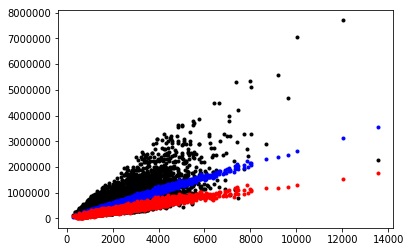

In [13]:
plt.plot(X_train[:,1],Y_train,'k.',
        X_train[:,1],predict_outcome(X_train, multiple_weights_0_penalty),'b.',
        X_train[:,1],predict_outcome(X_train, multiple_weights_high_penalty),'r.')

# k-fold cross validation to find l2-penalty

In [14]:
def k_fold_cross_validation(k, l2_penalty, data, output,features=False,degree=False):
    N = len(data)
    RSS_list=[]
    for i in range(k):
        #get the fold splits for the current iteration
        start = int(np.ceil((N*i)/k))
        end = int(np.ceil((N*(i+1))/k-1))
        training_data = data[0:start].append(data[end+1:N])
        validation_data = data[start:end+1]
        training_target = output[0:start].append(output[end+1:N])
        validation_target= output[start:end+1]
        
        #training on training split
        model = linear_model.Ridge(alpha=l2_penalty, normalize=True)
        if (features):
            model.fit(training_data[features], training_target)
        else:
            model.fit(training_data, training_target)
        
        #RSS on validation split
        validation_data.loc[:,'price']=validation_target
        if(degree):
            features = ["power_"+str(i) for i in range(1,degree+1)] 
        X,Y=dataframe_prepare(dataframe=validation_data,features=features,target=['price'])
        weights = np.concatenate((np.array([model.intercept_]), model.coef_),axis=0).reshape(-1,1) #merging intercept and coeffs
        RSS = compute_RSS(X,Y,weights)
        RSS_list.append(RSS)
    return RSS_list,np.mean(RSS_list)

In [15]:
def compute_RSS(X,y,w):
    RSS = np.matmul(np.transpose(y-predict_outcome(X,w)),y-predict_outcome(X,w))
    return RSS

In [16]:
df_train_ridge_shuffled = shuffle(df_train_ridge)
features = ['sqft_living', 'sqft_living15'] 
mean_RSS_list=[]

#get best l2-penalty using 10-fold cross validation
l2 = np.logspace(-9, 9, num=26)
for l2_penalty in l2:
    _ , mean_RSS = k_fold_cross_validation(k=10, l2_penalty=l2_penalty, data=df_train_ridge_shuffled, output=df_train_ridge_shuffled["price"],features=['sqft_living', 'sqft_living15'],degree=False)
    #print(mean_RSS)
    mean_RSS_list.append(mean_RSS)

val, idx = min((val, idx) for (idx, val) in enumerate(mean_RSS_list))
print("Best l2-penalty based on lowest RSS:"+str(l2[idx]))

#training new model using best l2-penalty
model = linear_model.Ridge(alpha=l2[idx], normalize=True)
model.fit(df_train_ridge_shuffled[features], df_train_ridge_shuffled["price"])
print("Weights of final model: ")
print(model.intercept_)
print(model.coef_)

#testing on test set

X_test,Y_test=dataframe_prepare(dataframe=df_test_ridge,features=features,target=['price'])
weights = np.concatenate((np.array([model.intercept_]), model.coef_),axis=0).reshape(-1,1)
test_RSS = compute_RSS(X_test,Y_test,weights)
print("Test set RSS with the best l2-penalty: "+str(test_RSS))

/Users/raiyanabdulbaten/Dropbox/ROC/handson-ml/my_codes/env/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/raiyanabdulbaten/Dropbox/ROC/handson-ml/my_codes/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Best l2-penalty based on lowest RSS:0.003019951720402013
Weights of final model: 
-99770.3868120372
[243.73362872  66.54793933]
Test set RSS with the best l2-penalty: [[2.7020516e+14]]


## Revisiting the polynomial regression problem with k-fold CV
Please refer to the polynomial regression code in the file 'Linear Regression Basics'. Here a maximum polynomial degree of 15 is used (which performed horribly without regularization). Using l2-penalty, the performance is improved.

In [17]:
train_valid_shuffled = load_csv_data("data","wk3_kc_house_train_valid_shuffled",dtype_dict)
test = load_csv_data("data","wk3_kc_house_test_data",dtype_dict)

In [18]:
def polynomial_dataframe(feature, degree):
    poly_dataframe = pd.DataFrame()
    poly_dataframe["power_1"] = feature
    if degree > 1:
        for power in range(2, degree+1):
            name = 'power_' + str(power)
            poly_dataframe[name] = feature.apply(lambda x: x**power)
    return poly_dataframe

In [19]:
degree=15
poly15_data = polynomial_dataframe(train_valid_shuffled['sqft_living'], degree)
mean_RSS_list=[]

#get best l2-penalty using 10-fold cross validation
l2 = np.logspace(-9, 9, num=26)
for l2_penalty in l2:
    _ , mean_RSS = k_fold_cross_validation(k=10, l2_penalty=l2_penalty, data=poly15_data, output=train_valid_shuffled["price"],features=False,degree=degree)
    #print(mean_RSS)
    mean_RSS_list.append(mean_RSS)

val, idx = min((val, idx) for (idx, val) in enumerate(mean_RSS_list))
print("Best l2-penalty based on lowest RSS:"+str(l2[idx]))

#training new model using best l2-penalty
model = linear_model.Ridge(alpha=l2[idx], normalize=True)
model.fit(poly15_data, train_valid_shuffled["price"])

#testing on test set
poly15_test = polynomial_dataframe(test['sqft_living'], degree)
poly15_test['price']=test['price']
features = ["power_"+str(i) for i in range(1,degree+1)] 
X_test,Y_test=dataframe_prepare(dataframe=poly15_test,features=features,target=['price'])
weights = np.concatenate((np.array([model.intercept_]), model.coef_),axis=0).reshape(-1,1)
test_RSS = compute_RSS(X_test,Y_test,weights)
print("Test set RSS with the best l2-penalty: "+str(test_RSS))

/Users/raiyanabdulbaten/Dropbox/ROC/handson-ml/my_codes/env/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/raiyanabdulbaten/Dropbox/ROC/handson-ml/my_codes/env/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/raiyanabdulbaten/Dropbox/ROC/handson-ml/my_codes/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyW

Best l2-penalty based on lowest RSS:0.08317637711026708
Test set RSS with the best l2-penalty: [[1.37392658e+14]]
